<a href="https://colab.research.google.com/github/rosshalpin/clip-guided-scene-arrangement/blob/main/DissertationProject_v0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import stable_baselines3
  import sb3_contrib
except ModuleNotFoundError:
  !pip install stable-baselines3[extra]
  !pip install git+https://github.com/Stable-Baselines-Team/stable-baselines3-contrib
  import stable_baselines3
  import sb3_contrib

In [2]:
try:
  import clip
except ModuleNotFoundError:
  !pip install git+https://github.com/openai/CLIP.git
  import clip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4oli1pe9
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-4oli1pe9
     |████████████████████████████████| 53 kB 1.6 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=c1a52f522d2368dcf7611ca52b77643c2660f1b8a2dbc3c168c545ffea8d8031
  Stored in directory: /tmp/pip-ephem-wheel-cache-0d5n5sa8/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [3]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'

!ln -s /content/drive/My\ Drive/Colab\ Notebooks/ $nb_path

sys.path.insert(0,nb_path)

!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/drive


In [4]:
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    import torch
    if torch.__version__.startswith("1.10.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install --target=$nb_path fvcore iopath
        !pip install --target=$nb_path --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install --target=$nb_path 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [5]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2022-08-13 21:04:56--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2022-08-13 21:04:56 (33.9 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



In [6]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.ops import sample_points_from_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, join_meshes_as_batch, join_meshes_as_scene, Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights,
    AmbientLights,
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [11]:
# # Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = '/content/drive/My Drive/DissertationProject_v0.0/data'

In [12]:
def load_mesh(input_path) -> Meshes:
  obj_filename = os.path.join(DATA_DIR, input_path)
  return load_objs_as_meshes([obj_filename], device=device)

In [13]:
fruit_mesh = load_mesh(f"{DATA_DIR}/fruit_mesh/pear_export.obj")
table_mesh = load_mesh(f"{DATA_DIR}/table_mesh/GenericClassicTable001.obj")

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 210MiB/s]


In [15]:
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [16]:
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [17]:
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

In [18]:
class SceneObject():
    def __init__(self, mesh, scale=1):
      new_mesh = mesh.clone().scale_verts(scale)
      self._mesh = new_mesh
      self._scale = scale
      self._position = self._mesh_position()

    @property
    def mesh(self):
      return self._mesh

    @property
    def position(self):
      return self._position

    @position.setter
    def position(self, value):
      offset = [round(a-b,3) for a, b in zip(value, self._position)]
      self._set_position_helper(offset)

    def _mesh_position(self):
      return [round(float(((c.cpu()[0]+c.cpu()[1])/2)), 3) for c in self._mesh.get_bounding_boxes()[0]]

    def _set_position_helper(self, value):
      offset = self._mesh.verts_padded().new_tensor(value).expand(self._mesh.verts_packed().shape)
      self._mesh = self._mesh.offset_verts(offset)
      self._position = self._mesh_position()

    def translate(self, value):
      self._set_position_helper(value)


In [19]:
from pytorch3d.renderer import (
  HardPhongShader
)

class Scene():
  def __init__(self, meshes: list, azim, elev, dist):
    self.AZIM = azim
    self.ELEV = elev
    self.num_cameras = max(len(self.AZIM), len(self.ELEV))
    self._meshes = meshes
    self.CAMERA_DIST = dist
    self._scene = join_meshes_as_scene(meshes).extend(self.num_cameras)
    self.device = device

  @property
  def scene(self):
    return self._scene

  @scene.setter
  def scene(self, value):
    self._scene = join_meshes_as_scene(value).extend(self.num_cameras)

  @property
  def _lights(self):
    return PointLights(device=device, location=[[0.0, 5.0, 7.0]])
    # return AmbientLights(device=self.device)

  @property
  def _cameras(self):
    R, T = look_at_view_transform(dist=self.CAMERA_DIST, azim=self.AZIM, elev=self.ELEV)
    return FoVPerspectiveCameras(device=self.device, R=R, T=T)

  @property
  def renderer(self):
    return MeshRenderer(
        rasterizer=MeshRasterizer(
            raster_settings=RasterizationSettings(
              image_size=256, 
              faces_per_pixel=1,
              bin_size=None
            )
        ),
        shader=HardPhongShader(
            device=self.device
        )
    )
  
  def render(self):
    return self.renderer(self.scene, cameras=self._cameras, lights=self._lights).cpu().numpy()


In [20]:
def clip_sim_3(input: list, description: str):
  text = clip.tokenize(description).to(device)
  with torch.no_grad():
    text_features = model.encode_text(text)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarities = []
  for image_input in input:
    # image_input = get_pil_image(image_input[0, ..., :3])
    image_input = preprocess(image_input).unsqueeze(0).to(device)

    with torch.no_grad():
      image_features = model.encode_image(image_input).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    # print(similarity[0][0])
    similarities.append(similarity[0][0])
  return similarities

In [53]:
import math
import random

def get_float_rand(inp):
  res = []
  for i in range(inp):
    res.append(round(random.uniform(0.28, 0.29), 6))
  return res

In [68]:
from scipy.stats import mannwhitneyu
# a=[0.3118739,0.3422155,0.3348432]
# b=[0.3288437,0.3137485,0.3048432]
a=[0,0,0]
b=[0,0,0]
# a = [math.log(x) for x in a]
# b = [math.log(x) for x in b]
stat, pvalue = mannwhitneyu(a, b)
print(stat, pvalue)

4.5 1.0


In [ ]:
# def clip_similarity(images: list, description: str):
#   text_tokens = clip.tokenize([description]).cuda()
#   images = map(preprocess, images)
#   image_input =  torch.tensor(np.stack(images)).cuda()
#   with torch.no_grad():
#     image_features = model.encode_image(image_input).float()
#     text_features = model.encode_text(text_tokens).float()

#   image_features /= image_features.norm(dim=-1, keepdim=True)
#   text_features /= text_features.norm(dim=-1, keepdim=True)
#   similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

#   return similarity[0]

In [21]:
from PIL import Image
def get_pil_image(input):
  return Image.fromarray((input * 255).astype('uint8'))

In [86]:
import time
from gym import Env
from gym.spaces import Box, MultiBinary
import random
import copy
from math import isnan

from scipy.stats import wilcoxon, ttest_ind, ttest_rel, mannwhitneyu

class CustomTrain(Env):
  def __init__(self, objs, guide, limit=None):
    self.GUIDE_STRING = guide

    self.limit = limit
    self.rounds = 0
    self.total_reward = -1

    self.camera_config = {
      'azim': torch.linspace(0, 180, 4),
      'elev': [45],
      'dist': 12.0
    }

    self.action_space = Box(low=-1, high=1, shape=(3,)) # MultiBinary(n=6)
    
    self.objs =  [copy.deepcopy(obj) for obj in objs]
    self.objs[0].position = self.action_space.sample()

    self.scene = Scene(
      meshes=[a.mesh for a in self.objs], 
      **self.camera_config
    )
    self.num_cameras = self.scene.num_cameras

    # self.observation_space = Box(low=0, high=1, shape=(self.num_cameras,))
    self.observation_space = Box(low=0, high=1, shape=(1,))
    
    self.state = self.objs[0].position

    self.best_sim_matrix = np.zeros(self.num_cameras).astype(np.float32)
    self.prev_sim_matrix = np.zeros(self.num_cameras).astype(np.float32)

    self.best = {}
    self.images = None

    self.limit_box = [[-10,-1,-10],[10,10,10]]
    self.p_threshold = 0.1
    self.dist_mod = 0.2

  def get_similarity(self):
    self.scene = Scene([a.mesh for a in self.objs], **self.camera_config)
    images = self.scene.render()
    pil_images = [get_pil_image(img[..., :3]) for img in images]
    self.images = images
    return clip_sim_3(pil_images, self.GUIDE_STRING)

  def limit_action(self, action, obj):
    limited = False
    translation_result = [a+b for a,b in zip (obj.position, action)]
    for i, val in enumerate(translation_result):
        if val < self.limit_box[0][i]:
            limited = True
        elif val > self.limit_box[1][i]:
            limited = True
    return limited

  def perform_test(self, a, b):
    stat, p = mannwhitneyu(a, b, alternative='greater')
    if isnan(stat):
      stat = 0
    if isnan(p):
      p = 0
    return stat, p

  def reward(self, sim_matrix, limited) -> int:
    rw = 0
    stat_best, p_best = self.perform_test(sim_matrix, self.best_sim_matrix)
    stat_prev, p_prev = self.perform_test(sim_matrix, self.prev_sim_matrix)
    print(self.objs[0].position, sim_matrix, self.prev_sim_matrix, p_prev)
    # stat_best = (2 *(stat_best - -100)/(100- -100)) - 1

    if p_best <= self.p_threshold:
      self.best_sim_matrix = sim_matrix
      self.best["images"] = self.images
      self.best["scene"] = self.scene.scene
      rw += stat_best
    elif p_best > self.p_threshold:
      # self.objs[0].position = initial_position
      rw += stat_best

    if p_prev <= self.p_threshold:
      print('better')
      rw += stat_prev
    elif p_prev > self.p_threshold:
      rw += stat_prev

    # rw += stat_best
    # rw += stat_prev
    
    if limited:
      rw = 0

    return rw, p_prev

  def step(self, action):
    info = {}
    done = False
    self.rounds += 1

    # action = [ a * 2 for a in action]

    # action = [ (a * -b) * self.dist_mod for a,b in zip(action[:3], action[3:])]

    initial_position = copy.deepcopy(self.objs[0].position)

    limited = self.limit_action(action[:3], self.objs[0])

    self.objs[0].translate(action)

    self.state = self.objs[0].position
    self.scene = [a.mesh for a in self.objs]

    sim_matrix = np.asarray(self.get_similarity()).astype(np.float32)

    rw, p_prev = self.reward(sim_matrix, limited)

    obs = np.asarray([p_prev]).astype(np.float32)

    if limited:
      self.objs[0].position = initial_position

    self.total_reward += rw

    info["obj"] = self.objs
    info["images"] = self.images
    info["best"] = self.best

    self.prev_sim_matrix = sim_matrix
    
    if self.limit != None and self.rounds > self.limit:
      done = True

    return obs, rw, done, info
  
  def reset(self):
    self.state = np.array([0,0,0])
    self.objs[0].position = self.action_space.sample()
    self.best_sim_matrix = np.zeros(self.num_cameras).astype(np.float32)
    self.total_reward = -1
    #return np.zeros(self.num_cameras).astype(np.float32)
    return np.zeros(1).astype(np.float32)

  def render(self, mode):
    pass
    # print(f"Round : {self.rounds}\nCLIP Score : {similarity} \nReward Received: {rw}")
    # print(f"Total Reward : {self.collected_reward}")

In [84]:
fruit_object = SceneObject(fruit_mesh, scale=0.25)

table_object = SceneObject(table_mesh, scale=8)
table_object.position=[0,0,0]

[0.886, 0.252, -1.004] [0.27540135 0.28491366 0.2850026  0.30406368] [0. 0. 0. 0.] 0.010535285067189329
better
[0.488, 0.525, -1.271] [0.27540135 0.28491366 0.28596264 0.32761985] [0.27540135 0.28491366 0.2850026  0.30406368] 0.4419262843666715
[-0.009, 1.229, -0.382] [0.27540135 0.28491366 0.2831392  0.27092913] [0.27540135 0.28491366 0.28596264 0.32761985] 0.9459683135312157
[-0.397, 0.294, -1.049] [0.27540135 0.28491366 0.2846017  0.3233766 ] [0.27540135 0.28491366 0.2831392  0.27092913] 0.15324608252079192
[0.586, 0.65, -1.742] [0.27540135 0.28491366 0.3251332  0.3192097 ] [0.27540135 0.28491366 0.2846017  0.3233766 ] 0.330598353968467
[1.464, 1.493, -2.496] [0.27962345 0.28937113 0.3488325  0.322222  ] [0.27540135 0.28491366 0.3251332  0.3192097 ] 0.34285714285714286
[1.307, 1.138, -1.499] [0.27540135 0.28491366 0.2914126  0.31408894] [0.27962345 0.28937113 0.3488325  0.322222  ] 0.8285714285714285
[0.863, 1.743, -0.618] [0.2754148  0.28495407 0.28320006 0.27090314] [0.27540135 0.

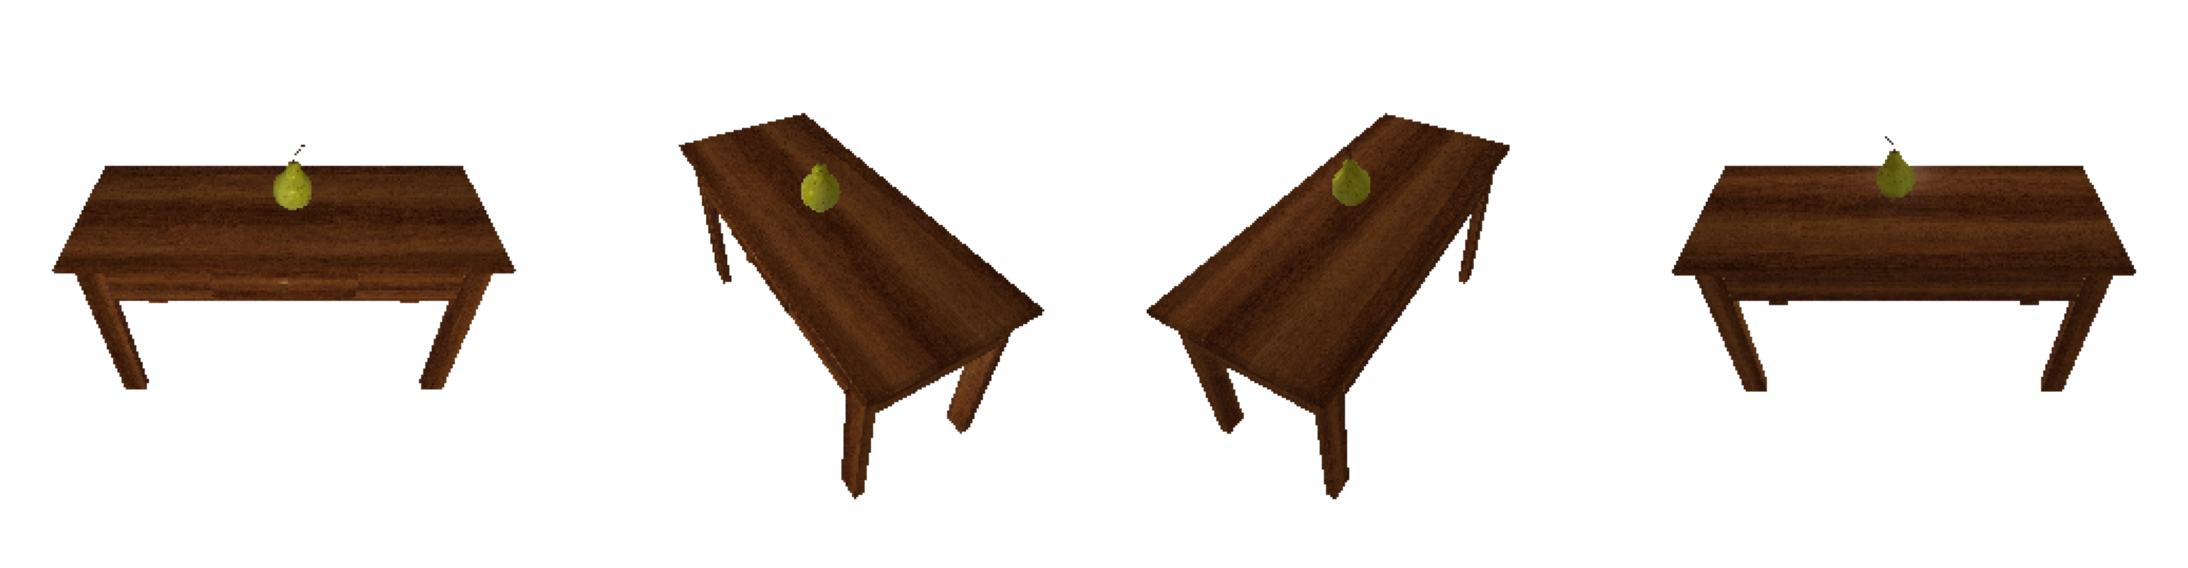

In [91]:
env = CustomTrain([fruit_object, table_object], "A piece of fruit on top of a wooden table", limit=100)
done = False
images = []
best = None
best_scene = None
while not done:
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  best = info["best"]["images"]
  best_scene = info["best"]["scene"]

image_grid(best, rows=1, cols=4, rgb=True)

In [34]:
best = None

In [32]:
from torch import cuda

cuda.empty_cache()

In [90]:
plot_batch_individually(best_scene[0])

In [30]:
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_checker import check_env

env = CustomTrain([fruit_object, table_object], "A piece of fruit on a wooden table")
check_env(env, warn=True)

n_envs = 4

env = make_vec_env(lambda: env, n_envs=n_envs)

In [ ]:
n_steps = 64
total_timesteps = (n_steps * n_envs) * 10
train_model = PPO('MlpPolicy', env, verbose=1, n_steps=n_steps).learn(n_eval_episodes=10, total_timesteps=total_timesteps)

In [ ]:
# Test the trained agent
obs = env.reset()
n_steps = 10
_info = None
for step in range(n_steps):
  cuda.close()
  action, _ = train_model.predict(obs, deterministic=True)
  obs, reward, done, info = env.step(action)
  _info = info

image_grid(_info[0]["best"]["images"], rows=1, cols=4, rgb=True)

In [ ]:
# from sb3_contrib import TRPO

# model = TRPO("MlpPolicy", env, verbose=1).learn(total_timesteps=100, log_interval=4)

In [ ]:
# train_model = A2C("MlpPolicy", env, verbose=1).learn(n_eval_episodes=50, total_timesteps=1000)

In [ ]:
# from sb3_contrib import RecurrentPPO

# train_model = RecurrentPPO("MlpLstmPolicy", env, verbose=1, n_steps=128).learn(n_eval_episodes=200,total_timesteps=10000)

In [ ]:
# obs = env.reset()
# n_steps=10
# # cell and hidden state of the LSTM
# lstm_states = None
# num_envs = 1
# # Episode start signals are used to reset the lstm states
# episode_starts = np.ones((num_envs,), dtype=bool)
# _info = None
# for step in range(n_steps):
#     action, lstm_states = train_model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)
#     obs, rewards, done, info = env.step(action)
#     _info = info
#     episode_starts = done

# image_grid(_info[0]["best"]["images"], rows=1, cols=4, rgb=True)

In [ ]:
# from stable_baselines3 import SAC

# train_model = SAC("MlpPolicy", env, verbose=1, device="cuda").learn(n_eval_episodes=100,total_timesteps=1000)

In [ ]:
# from stable_baselines3 import TD3
# from stable_baselines3.common.noise import NormalActionNoise

# n_actions = env.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

In [ ]:
# train_model = TD3("MlpPolicy", env, train_freq=(5, "step"), action_noise=action_noise, verbose=1, device=device).learn(total_timesteps=1, log_interval=10)

In [ ]:
plot_batch_individually(best_scene[0])